Import Wind Data

In [12]:
import csv
import itertools

# Open the CSV file
with open('ninja_wind_59.4762_13.3026_corrected.csv', newline='') as csvfile:
    # Create a CSV reader object
    reader = csv.reader(csvfile, delimiter=',')

    # Initialize an empty list to store the rows
    rows = []

    # Loop over the rows in the CSV file and append them to the list
    for row in reader:
        rows.append(row)

reduced_list = list(itertools.chain(*rows))
wind_data = [float(x) for x in reduced_list]
print(wind_data)
print(len(wind_data))

[82222.464, 71909.45, 67657.565, 69458.625, 69803.901, 62120.425, 58560.925, 54939.715, 54254.401, 53450.717, 56082.691, 62096.533, 65803.969, 66341.081, 71118.907, 80767.395, 89001.678, 92351.652, 93118.299, 94374.85, 94848.868, 94399.96, 89997.365, 89361.664, 88720.93, 86351.439, 84029.202, 81174.028, 82719.558, 79081.803, 69412.53, 60984.516, 58715.94, 56324.392, 53217.401, 50647.843, 48384.306, 48512.387, 47870.104, 45521.519, 37710.888, 32818.041, 25245.447, 39370.985, 39552.484, 31963.979, 36734.136, 32518.197, 26458.695, 25257.192, 25185.603, 16560.891, 14407.865, 11953.567, 10382.647, 9590.756, 5308.887, 2392.073, 5207.18, 7868.391, 11770.743, 15181.5, 20068.092, 17421.981, 14723.224, 12289.002, 10442.699, 9342.146, 8375.864, 7806.534, 8550.505, 9278.169, 9972.633, 10124.528, 10472.42, 13198.086, 18784.799, 24523.515, 26394.413, 27256.026, 27684.841, 26472.534, 24359.68, 23073.784, 24400.131, 27201.113, 26302.854, 24546.841, 22032.886, 18564.555, 21004.301, 16594.741, 13310.768

Import Price Data (Day Ahead)

In [94]:
import pulp
import numpy as np

def runOptimization(size):
    # Wind energy production data
    wind_data = [91.0671,
    94.3884,
    96.623,
    97.9732,
    98.5202,
    98.6897,
    98.8975,
    98.9038,
    98.9578,
    99.0083,
    99.0768,
    99.1255,
    99.0988,
    98.9152,
    98.0046,
    95.7916,
    93.0839,
    90.3289,
    88.8394,
    89.0865,
    90.1445,
    92.4519,
    93.3636,
    93.762
    ]
    prices_day = [  46.60, 
    41.33,
    42.18, 
    44.37, 
    37.67, 
    39.70, 
    40.59, 
    43.26, 
    49.66, 
    70.05, 
    76.79, 
    84.10, 
    94.74, 
    96.80, 
    97.17, 
    101.27, 
    126.60 ,
    149.97 ,
    146.33 ,
    140.28 ,
    121.88 ,
    102.61 ,
    95.12 ,
    83.11 
    ]
    prices_bal = [ 46.60, 
    41.33, 
    42.18, 
    44.37, 
    37.67, 
    39.70, 
    40.59, 
    43.26, 
    49.44, 
    49.46, 
    49.27, 
    48.89, 
    48.45, 
    48.74, 
    49.06, 
    49.56, 
    50.28, 
    50.92,
    49.42, 
    48.72, 
    48.28, 
    47.61, 
    47.23, 
    46.74 
    ]

    # Battery capacity (MWh)
    battery_capacity = size

    # Battery state of charge constraints
    soc_min = 0.1 * battery_capacity
    soc_max = 0.9 * battery_capacity

    # Create problem instance
    problem = pulp.LpProblem("Wind farm revenue maximization", pulp.LpMaximize)

    # Define decision variables
    E_bal = pulp.LpVariable.dict("E_bal", range(24), lowBound=0, cat=pulp.LpContinuous)
    E_day = pulp.LpVariable.dict("E_day", range(24), lowBound=0, cat=pulp.LpContinuous)
    SOC = pulp.LpVariable.dict("SOC", range(25), lowBound=0, upBound=battery_capacity, cat=pulp.LpContinuous)

    # Objective function
    revenue = sum(prices_day[t]*E_day[t] + prices_bal[t]*E_bal[t] for t in range(24))
    problem += revenue

    # Wind power production constraint
    for t in range(24):
        problem += E_day[t] + E_bal[t] <= wind_data[t] + SOC[t], f"Wind power production constraint at hour {t}"

    # State of charge constraint
    SOC[0] = soc_min  # initial state of charge
    for t in range(1, 25):
        problem += SOC[t-1] + 0.95*(wind_data[t-1] - E_bal[t-1] - E_day[t-1]) == SOC[t], f"SOC constraint at hour {t}"
        problem += soc_min <= SOC[t], f"SOC lower bound at hour {t}"
        problem += SOC[t] <= soc_max, f"SOC upper bound at hour {t}"

    # Final state of charge constraint
    problem += SOC[24] == SOC[0], "Final SOC constraint"

    # Solve the problem
    status = problem.solve()

    # Print the optimal solution
    # print(f"Optimal revenue: ${problem.objective.value():,.2f}")
    # print(f"Hour 0: E_day = 0 MWh, E_bal = 0 MWh, SOC = {SOC[0]} MWh")
    return problem.objective.value()

    # batteryStateOfCharge  =  np.empty(25)
    # batteryStateOfCharge[0] = SOC[0]
    # for t in range(24):
        # batteryStateOfCharge[t+1] = SOC[t+1].value()
        # print(f"Hour {t+1}: E_day = {E_day[t].value():,.2f} MWh, E_bal = {E_bal[t].value():,.2f} MWh, SOC = {SOC[t+1].value():,.2f} MWh")    


In [105]:
rangeOfSizes = np.arange(0, 501, 1, dtype=float)
rangeOfSizes *= 5
print(rangeOfSizes)
resultsArray = np.zeros(len(rangeOfSizes))
print(resultsArray)



for i in range(len(rangeOfSizes)):
    resultsArray[i] = runOptimization(float(rangeOfSizes[i]))

print(resultsArray)

[   0.    5.   10.   15.   20.   25.   30.   35.   40.   45.   50.   55.
   60.   65.   70.   75.   80.   85.   90.   95.  100.  105.  110.  115.
  120.  125.  130.  135.  140.  145.  150.  155.  160.  165.  170.  175.
  180.  185.  190.  195.  200.  205.  210.  215.  220.  225.  230.  235.
  240.  245.  250.  255.  260.  265.  270.  275.  280.  285.  290.  295.
  300.  305.  310.  315.  320.  325.  330.  335.  340.  345.  350.  355.
  360.  365.  370.  375.  380.  385.  390.  395.  400.  405.  410.  415.
  420.  425.  430.  435.  440.  445.  450.  455.  460.  465.  470.  475.
  480.  485.  490.  495.  500.  505.  510.  515.  520.  525.  530.  535.
  540.  545.  550.  555.  560.  565.  570.  575.  580.  585.  590.  595.
  600.  605.  610.  615.  620.  625.  630.  635.  640.  645.  650.  655.
  660.  665.  670.  675.  680.  685.  690.  695.  700.  705.  710.  715.
  720.  725.  730.  735.  740.  745.  750.  755.  760.  765.  770.  775.
  780.  785.  790.  795.  800.  805.  810.  815.  8

c:\Users\raiya\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


[186445.94223    186931.58447632 187417.22634991 187902.8687462
 188388.5115924  188874.1524162  189359.7952624  189845.4361652
 190331.0789324  190816.7217786  191302.3626814  191788.0055276
 192273.6482948  192759.2891976  193244.9320438  193730.5728676
 194216.2157138  194701.85856    195187.4993838  195673.14223
 196158.7850762  196644.42591653 197130.0687541  197613.62593185
 198090.54698204 198564.06351336 199037.57810128 199511.09455072
 199984.61108204 200458.12566996 200931.64220128 201405.15865072
 201878.67323864 202352.18976996 202825.704276   203299.22080732
 203772.73733864 204246.25184468 204719.768376   205193.28490732
 205666.79941336 206140.31594468 206613.832476   207087.34699891
 207560.86351758 208034.3780849  208502.04115885 208965.72693597
 209426.27337003 209886.82130379 210347.36919696 210807.91563102
 211268.46356478 211729.00995825 212189.55789201 212650.10582577
 213110.65221924 213571.200153   214031.74808676 214492.29448023
 214952.84241399 215413.39034775

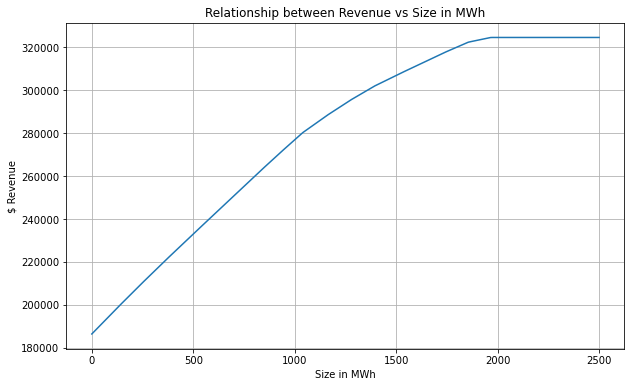

In [111]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# create a list of x-axis values for the time series data
x = list(range(len(resultsArray)))

# create a line chart with seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x=rangeOfSizes, y=resultsArray)

# set the title and axis labels
plt.title('Relationship between Revenue vs Size in MWh')
plt.xlabel('Size in MWh')
plt.ylabel('$ Revenue')

# add gridlines to the chart
plt.grid()

# show the chart
plt.show()


In [ ]:
#look into capacity in terms of MW, has to do with the dynamics of pipes/water flow rate/ 
# use real life data